In [35]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Impor the OpenWeatherMap API key
from api_key import key
from geoapi import geo_apikey

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

In [36]:
import requests
import json
# Set base URL
base_url = "https://api.census.gov/data"
year = '/2022'
data_name = '/acs/acs1/subject'
#all of the B02015 table ID data for all states
#qry = '?get=group(S1903)&for=place'
qry = "?get=NAME,S1903_C03_001E&for=place"
key = str('&key='+ key)

    # Make an API request using the params dictionary
test = str(base_url + year + data_name + qry + key)
test
response = requests.get(base_url + year + data_name + qry + key)
result = response.json()
print (json.dumps(result, indent=4))


[
    [
        "NAME",
        "S1903_C03_001E",
        "state",
        "place"
    ],
    [
        "Auburn city, Alabama",
        "54839",
        "01",
        "03076"
    ],
    [
        "Birmingham city, Alabama",
        "39326",
        "01",
        "07000"
    ],
    [
        "Dothan city, Alabama",
        "53929",
        "01",
        "21184"
    ],
    [
        "Hoover city, Alabama",
        "103194",
        "01",
        "35896"
    ],
    [
        "Huntsville city, Alabama",
        "68930",
        "01",
        "37000"
    ],
    [
        "Mobile city, Alabama",
        "50051",
        "01",
        "50000"
    ],
    [
        "Montgomery city, Alabama",
        "55108",
        "01",
        "51000"
    ],
    [
        "Tuscaloosa city, Alabama",
        "49005",
        "01",
        "77256"
    ],
    [
        "Anchorage municipality, Alaska",
        "100751",
        "02",
        "03000"
    ],
    [
        "Avondale city, Arizona",
        "66801

In [37]:
median_income = 74580
# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Convert JSON data to DataFrame
    df = pd.DataFrame(data[1:], columns=data[0:])
    
    # Save the DataFrame to a CSV file
    df.to_csv("../data/census_data.csv", index=False)
    print("Data saved to census_data.csv")
else:
    print("Error:", response.status_code)

Data saved to census_data.csv


In [38]:
# Convert the cities weather data into a Pandas DataFrame
city_eco_data_df  = pd.read_csv('../data/census_data.csv')

# Splitting the 'NAME' column into two columns 'City' and 'State'
city_eco_data_df[['City', 'State']] = city_eco_data_df['NAME'].str.split(', ', expand=True)
#city_eco_data_df.drop(columns=['NAME'], inplace=True)

# Show Record Count
city_eco_data_df.count()
city_eco_data_df.head()

,NAME,S1903_C03_001E,state,place,City,State
0,"Auburn city, Alabama",54839,1,3076,Auburn city,Alabama
1,"Birmingham city, Alabama",39326,1,7000,Birmingham city,Alabama
2,"Dothan city, Alabama",53929,1,21184,Dothan city,Alabama
3,"Hoover city, Alabama",103194,1,35896,Hoover city,Alabama
4,"Huntsville city, Alabama",68930,1,37000,Huntsville city,Alabama


In [39]:
## splitting the eco median data into low income and high income..
city_eco_data_df = pd.DataFrame(city_eco_data_df)
city_eco_data_df = city_eco_data_df.drop_duplicates()
#city_eco_data_df = city_eco_data_df.drop_duplicates(subset=['City'])
# Splitting the DataFrame into two based on the condition
threshold_value = 74580
df_above_threshold = city_eco_data_df[city_eco_data_df['S1903_C03_001E'] > threshold_value]
df_below_threshold = city_eco_data_df[city_eco_data_df['S1903_C03_001E'] <= threshold_value]

len(city_eco_data_df), len(df_below_threshold), len(df_below_threshold)
#df_above_threshold, df_below_threshold

(646, 320, 320)

In [40]:
#the Geoapify Geocoding service URL for getting Coords
def get_coordinates(city_name, geo_apikey):
    base_url = "https://api.geoapify.com/v1/geocode/search"
    params = {
        "text": city_name,
        "apiKey": geo_apikey
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data['features']:
            # Extracting the first result's coordinates
            coordinates = data['features'][0]['geometry']['coordinates']
            return coordinates
        else:
            return "No results found"
    else:
        return "Error in API request"

# pull the data
api_key = geo_apikey # Replace with your actual Geoapify API key
city_name1 = "New York"
coordinates = get_coordinates(city_name1, api_key)
print(f"Coordinates of {city_name1}: {coordinates}")

Coordinates of New York: [-74.0060152, 40.7127281]


In [41]:
# Path to the CSV file
coord_csv_file_path = "../data/city_coordinates.csv"

# Read and display the first few rows of the saved CSV file for verification
city_coordinates_df = pd.read_csv(coord_csv_file_path)
print(city_coordinates_df.head())

                       City   Latitude  Longitude
0      Auburn city, Alabama  32.601014 -85.516657
1  Birmingham city, Alabama  33.599853 -86.632216
2      Dothan city, Alabama  31.221808 -85.378001
3      Hoover city, Alabama  33.387197 -86.805680
4  Huntsville city, Alabama  34.729847 -86.585901


In [42]:
try:
    existing_data_df = city_coordinates_df
except FileNotFoundError:
    existing_data_df = pd.DataFrame(columns=['City', 'Latitude', 'Longitude'])

# Write headers to the CSV file if it's empty
if existing_data_df.empty:
    existing_data_df.to_csv(coord_csv_file_path, index=False)

# Iterating through the cities and fetching coordinates
for city in city_eco_data_df['NAME']:
    # Check if the city is already in the existing data
    if city not in existing_data_df['City'].values:
        coordinates = get_coordinates(city, api_key)
        if coordinates != [None, None]:
            # Creating a DataFrame for the current city
            temp_df = pd.DataFrame([{
                'City': city,
                'Latitude': coordinates[1],  # Latitude
                'Longitude': coordinates[0]  # Longitude
            }])
            
            # Append the current city's data to the CSV file
            temp_df.to_csv(coord_csv_file_path, mode='a', header=False, index=False)
            print(f"Getting data for {city}")
        else:
            print(f"Failed to fetch coordinates for {city}")
    else:
        print(f"{city} already exists in the dataset.")


Auburn city, Alabama already exists in the dataset.
Birmingham city, Alabama already exists in the dataset.
Dothan city, Alabama already exists in the dataset.
Hoover city, Alabama already exists in the dataset.
Huntsville city, Alabama already exists in the dataset.
Mobile city, Alabama already exists in the dataset.
Montgomery city, Alabama already exists in the dataset.
Tuscaloosa city, Alabama already exists in the dataset.
Anchorage municipality, Alaska already exists in the dataset.
Avondale city, Arizona already exists in the dataset.
Buckeye city, Arizona already exists in the dataset.
Casas Adobes CDP, Arizona already exists in the dataset.
Chandler city, Arizona already exists in the dataset.
Flagstaff city, Arizona already exists in the dataset.
Gilbert town, Arizona already exists in the dataset.
Glendale city, Arizona already exists in the dataset.
Goodyear city, Arizona already exists in the dataset.
Maricopa city, Arizona already exists in the dataset.
Mesa city, Arizona

In [43]:
# Read and display the first few rows of the saved CSV file for verification
city_coordinates_df = pd.read_csv(coord_csv_file_path)
city_coordinates_df = city_coordinates_df.drop_duplicates()
print(city_coordinates_df.head())

                       City   Latitude  Longitude
0      Auburn city, Alabama  32.601014 -85.516657
1  Birmingham city, Alabama  33.599853 -86.632216
2      Dothan city, Alabama  31.221808 -85.378001
3      Hoover city, Alabama  33.387197 -86.805680
4  Huntsville city, Alabama  34.729847 -86.585901


In [44]:
print(str(len(city_coordinates_df)) + ' compared to the source list length of: ' + str(len(city_eco_data_df)))

646 compared to the source list length of: 646


In [45]:
#using the csv previously created on first run to save time during testing/processing this code
#do not execute this cell if you are running the first time.
high_inc_merged_df = pd.read_csv("../data/high_inc_data_cleaned.csv")
low_inc_merged_df = pd.read_csv("../data/low_inc_data_cleaned.csv")

In [49]:
radius = 6600  # 10 kilometers
categories = "activity.sport_club"
limit =  500
# Iterate through the DataFrame
for index, row in high_inc_merged_df.iterrows():
    lat, lon = row['Lat'], row['Lon']  # Ensure these are the correct column names for latitude and longitude

    # Update the params dictionary with dynamic values
    params = {
        "apiKey": geo_apikey,
        "limit": limit,
        "categories": categories,
        "filter": f"circle:{lon},{lat},{radius}",
        "bias": f"proximity:{lon},{lat}"
    }

    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make an API request using the params dictionary
    clubs = requests.get(base_url, params=params).json()
   
    # Process each park found
    club_coordinates = []

    # for feature in parks.get("features", []):
    for feature in clubs.get("features", []):
        ##Extracting coordinates
        coordinates = feature["geometry"]["coordinates"]
        club_coordinates.append(coordinates)

    # Save the club count and coordinates to the DataFrame
    high_inc_merged_df.loc[index, "Sport Club Count"] = len(club_coordinates)


    print(f"{row['Cities']} - Number of Sports Clubs found: {high_inc_merged_df.loc[index, 'Sport Club Count']}")

Hoover - Number of Sports Clubs found: 0.0
Anchorage municipality - Number of Sports Clubs found: 2.0
Buckeye - Number of Sports Clubs found: 0.0
Casas Adobes - Number of Sports Clubs found: 0.0
Chandler - Number of Sports Clubs found: 3.0
Gilbert - Number of Sports Clubs found: 7.0
Goodyear - Number of Sports Clubs found: 0.0
Maricopa - Number of Sports Clubs found: 0.0
Mesa - Number of Sports Clubs found: 4.0
Peoria - Number of Sports Clubs found: 5.0
Phoenix - Number of Sports Clubs found: 0.0
Queen Creek - Number of Sports Clubs found: 1.0
San Tan Valley - Number of Sports Clubs found: 0.0
Scottsdale - Number of Sports Clubs found: 0.0
Surprise - Number of Sports Clubs found: 2.0
Tempe - Number of Sports Clubs found: 2.0
Rogers - Number of Sports Clubs found: 0.0
Alameda - Number of Sports Clubs found: 5.0
Anaheim - Number of Sports Clubs found: 0.0
Antioch - Number of Sports Clubs found: 0.0
Berkeley - Number of Sports Clubs found: 0.0
Brentwood - Number of Sports Clubs found: 4.0

In [50]:
#high_inc_merged_df.to_csv('../data/high_inc_data.csv', index=False)
high_inc_merged_df.head()

,Unnamed: 0,Cities,States,Lat,Lon,High Income,Sport Clubs Count,Sport Club Count
0,0,Hoover,Alabama,33.387197,-86.805680,103194,0.0,0.0
1,1,Anchorage municipality,Alaska,61.216313,-149.894852,100751,NaN,2.0
2,2,Buckeye,Arizona,33.370320,-112.583776,95235,NaN,0.0
3,3,Casas Adobes,Arizona,32.340932,-111.010201,75650,NaN,0.0
4,4,Chandler,Arizona,33.306203,-111.841185,98664,NaN,3.0


In [51]:
radius = 6600  # 10 kilometers
categories = "activity.sport_club"
limit =  500
# Iterate through the DataFrame
for index, row in low_inc_merged_df.iterrows():
    lat, lon = row['Lat'], row['Lon']  # Ensure these are the correct column names for latitude and longitude

    # Update the params dictionary with dynamic values
    params = {
        "apiKey": geo_apikey,
        "limit": limit,
        "categories": categories,
        "filter": f"circle:{lon},{lat},{radius}",
        "bias": f"proximity:{lon},{lat}"
    }

    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make an API request using the params dictionary
    clubs = requests.get(base_url, params=params).json()
   
    # Process each park found
    club_coordinates = []

    # for feature in parks.get("features", []):
    for feature in clubs.get("features", []):
        ##Extracting coordinates
        coordinates = feature["geometry"]["coordinates"]
        club_coordinates.append(coordinates)

    # Save the club count and coordinates to the DataFrame
    low_inc_merged_df.loc[index, "Sport Club Count"] = len(club_coordinates)


    print(f"{row['Cities']} - Number of Sports Clubs found: {low_inc_merged_df.loc[index, 'Sport Club Count']}")

Auburn - Number of Sports Clubs found: 0.0
Birmingham - Number of Sports Clubs found: 1.0
Dothan - Number of Sports Clubs found: 0.0
Huntsville - Number of Sports Clubs found: 1.0
Mobile - Number of Sports Clubs found: 0.0
Montgomery - Number of Sports Clubs found: 0.0
Tuscaloosa - Number of Sports Clubs found: 0.0
Avondale - Number of Sports Clubs found: 0.0
Flagstaff - Number of Sports Clubs found: 0.0
Glendale - Number of Sports Clubs found: 0.0
Tucson - Number of Sports Clubs found: 0.0
Yuma - Number of Sports Clubs found: 0.0
Conway - Number of Sports Clubs found: 0.0
Fayetteville - Number of Sports Clubs found: 0.0
Fort Smith - Number of Sports Clubs found: 0.0
Jonesboro - Number of Sports Clubs found: 1.0
Little Rock - Number of Sports Clubs found: 1.0
Springdale - Number of Sports Clubs found: 0.0
Alhambra - Number of Sports Clubs found: 0.0
Apple Valley - Number of Sports Clubs found: 0.0
Arden-Arcade - Number of Sports Clubs found: 0.0
Bakersfield - Number of Sports Clubs fou

In [52]:
low_inc_merged_df.head()

,Unnamed: 0,Cities,States,Lat,Lon,Low Income,Sport Club Count
0,0,Auburn,Alabama,32.601014,-85.516657,54839,0.0
1,1,Birmingham,Alabama,33.599853,-86.632216,39326,1.0
2,2,Dothan,Alabama,31.221808,-85.378001,53929,0.0
3,3,Huntsville,Alabama,34.729847,-86.585901,68930,1.0
4,4,Mobile,Alabama,30.689362,-88.051896,50051,0.0


In [54]:


# Calculate average bar count in high and low income cities
high_avg = high_inc_merged_df['Sport Club Count'].mean()
low_avg = low_inc_merged_df['Sport Club Count'].mean()

print(f"Average Sport Club Count in High Income Cities: {high_avg}")
print(f"Average Sport Club Count in Low Income Cities: {low_avg}")



Average Sport Club Count in High Income Cities: 0.7147239263803681
Average Sport Club Count in Low Income Cities: 0.553125


In [55]:
# Define a function to create Linear Regression plots

def create_linear_regression_plot(x_values, y_values):
    # Calculate linear regression values
    slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    if intercept > 0:
        lin_eq = "y = " + str(round(slope,2)) + "x + " + str(round(slope,2))
    else:
        lin_eq = "y = " + str(round(slope,2)) + "x - " + str(round(abs(intercept),2))
    
    # Create scatter plot
    plt.scatter(x_values, y_values, label='Data points')
    
    # Create regression line plot
    plt.plot(x_values, regress_values, color='red', label='Linear Regression')
    plt.annotate(lin_eq,(20, 15), fontsize=15, color="red")
    
    plt.xlabel("Median Income")
    plt.ylabel("Sport Club Count")
    
    # Show the plot
    plt.show()

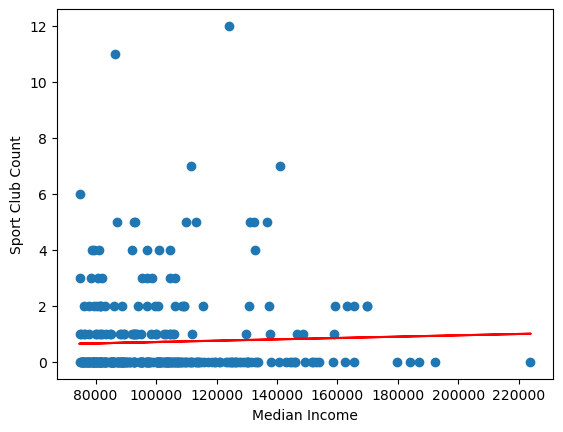

In [57]:
create_linear_regression_plot(high_inc_merged_df['High Income'], high_inc_merged_df['Sport Club Count'])

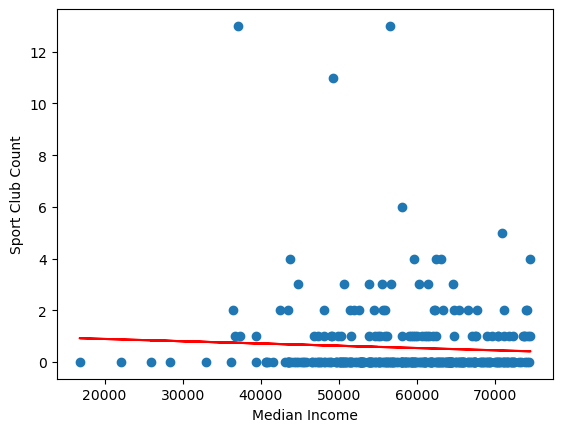

In [58]:
create_linear_regression_plot(low_inc_merged_df['Low Income'], low_inc_merged_df['Sport Club Count'])